<a href="https://colab.research.google.com/github/opdrin09/Arquivos_colab/blob/main/razaoeirhoa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cálculos analíticos

In [ ]:
import Pkg
Pkg.add(["Statistics", "Interpolations", "Trapz", "Printf", "HTTP", "CSV", "DataFrames"])

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Trapz ─ v2.0.3
    Updating `~/.julia/environments/v1.10/Project.toml`
  [cd3eb016] + HTTP v1.10.16
⌅ [a98d9a8b] + Interpolations v0.15.1
  [592b5752] + Trapz v2.0.3
  [de0858da] + Printf
  [10745b16] + Statistics v1.10.0
    Updating `~/.julia/environments/v1.10/Manifest.toml`
  [592b5752] + Trapz v2.0.3
Precompiling packages...
   3507.6 ms  ✓ Trapz
  1 dependency successfully precompiled in 13 seconds. 461 already precompiled.


Este código escala as dimensões de uma torre (altura $h$ em metros, diâmetro $d$ e largura da parede $w$ em milímetros) por um fator $\gamma = \frac{1}{100}$ para facilitar cálculos. A largura da parede é convertida para metros antes do escalonamento. O módulo de elasticidade também é escalado por $\gamma$, enquanto a densidade permanece constante.

In [ ]:
# --- Célula 1: Pacotes e Carregamento de Dados ---
using Interpolations, Trapz, HTTP, CSV, DataFrames

# Helper para mostrar LaTeX
struct LaTeXString; s::String; end
Base.show(io::IO, ::MIME"text/latex", l::LaTeXString) = write(io, "\$\$ " * l.s * " \$\$")
Base.show(io::IO, l::LaTeXString) = write(io, l.s)

# Inicializa arrays vazios para guardar os dados
tower_height = Float64[]
diametro = Float64[]
larg_da_parede = Float64[]

# Carrega dados da URL
println("Carregando dados da web...")
url_0 = "https://raw.githubusercontent.com/opdrin09/Arquivos_colab/refs/heads/main/IEA-15-240-RWT_tabular.csv"
resp = HTTP.get(url_0)
df_0 = CSV.read(resp.body, DataFrame)

# Preenche os arrays com os dados do arquivo
for row in eachrow(df_0)
    push!(tower_height, parse(Float64, string(row["Height [m]"])))
    push!(diametro, parse(Float64, string(row["OD [m]"])))
    push!(larg_da_parede, parse(Float64, string(row["Thickness [mm]"])))
end
println("Dados carregados com sucesso!")

# --- Célula 2: Separação, Escalonamento e Funções ---

# Separa os dados em Monopile e Torre
monopile_indices = (tower_height .>= -75) .& (tower_height .< 15)
torre_indices = tower_height .>= 15

# Dados da Torre e Monopile
h_torre, d_torre, esp_torre = tower_height[torre_indices], diametro[torre_indices], larg_da_parede[torre_indices]
h_monopile, d_monopile, esp_monopile = tower_height[monopile_indices], diametro[monopile_indices], larg_da_parede[monopile_indices]

# Constantes e Fator de Escala
γ = 1 / 100
E_aco = 200e9 * γ
ρ_aco = 7800.0
M_RNA_original = 0.947198397830578

# Aplica o fator de escala γ
h_torre_r = [h * γ for h in h_torre]
d_torre_r = [d * γ for d in d_torre]
esp_torre_r = [w * 1e-3 * γ for w in esp_torre]

h_monopile_r = [h * γ for h in h_monopile]
d_monopile_r = [d * γ for d in d_monopile]
esp_monopile_r = [w * 1e-3 * γ for w in esp_monopile]

# Funções de Geometria e Análise
A(de, di) = (de^2 - di^2) * π / 4
I(de, di) = (de^4 - di^4) * π / 64

function calcular_media_integral(x_pontos, y_pontos)
    if length(x_pontos) < 2; return 0.0, 0.0; end
    perm = sortperm(x_pontos); x_sorted, y_sorted = x_pontos[perm], y_pontos[perm]
    itp = linear_interpolation(x_sorted, y_sorted, extrapolation_bc=Line())
    x_fit = range(minimum(x_sorted), maximum(x_sorted), length=500)
    y_fit = itp.(x_fit)
    intervalo = maximum(x_sorted) - minimum(x_sorted)
    area_integral = trapz(x_fit, y_fit)
    media_integral = area_integral / intervalo
    return media_integral, area_integral
end

# --- FUNÇÃO PARA CALCULAR AS 3 FREQUÊNCIAS ---
function calcular_frequencias(L, K_flex, M_torre, M_rna, X_ratio)
    # Raleigh
    f_raleigh = sqrt(3 * K_flex / L^3 / ((33/140) * M_torre + M_rna)) / (2π)
    # Tempel
    f_tempel = sqrt(3.04 * K_flex / L^3 / (0.227 * M_torre + M_rna)) / (2π)
    # Cmp (Correção do Monopile)
    G = 0.45 / L
    C_mp = 1 / sqrt(1 + X_ratio * (1 + G)^3 - X_ratio)
    f_cmp = C_mp * f_tempel

    return (raleigh=f_raleigh, tempel=f_tempel, cmp=f_cmp)
end


# --- CASO 1: Original Reduzido (Referência) ---
println("\n--- CASO 1: Original Reduzido (Aço) ---")
Area_torre_ref = [A(de, de - 2 * esp) for (de, esp) in zip(d_torre_r, esp_torre_r)]
MoI_torre_ref = [I(de, de - 2 * esp) for (de, esp) in zip(d_torre_r, esp_torre_r)]
MoI_monopile_ref = [I(de, de - 2 * esp) for (de, esp) in zip(d_monopile_r, esp_monopile_r)]

media_A_torre_ref, area_A_torre_ref = calcular_media_integral(h_torre_r, Area_torre_ref)
media_I_torre_ref, _ = calcular_media_integral(h_torre_r, MoI_torre_ref)
media_I_monopile_ref, _ = calcular_media_integral(h_monopile_r, MoI_monopile_ref)

M_RNA_ref = 0.947198397830578
Massa_torre_ref = ρ_aco * area_A_torre_ref
raz = M_RNA_ref/Massa_torre_ref
Rigidez_flexao_ref = E_aco * media_I_torre_ref
L_T_r = maximum(h_torre_r) - minimum(h_torre_r)
X_ref = media_I_torre_ref / media_I_monopile_ref

freqs_ref = calcular_frequencias(L_T_r, Rigidez_flexao_ref, Massa_torre_ref, M_RNA_ref, X_ref)
display(LaTeXString("f_{Raleigh} = $(round(freqs_ref.raleigh, digits=4)) \\,\\mathrm{Hz}"))
display(LaTeXString("f_{Tempel} = $(round(freqs_ref.tempel, digits=4)) \\,\\mathrm{Hz}"))
display(LaTeXString("f_{Cmp} = $(round(freqs_ref.cmp, digits=4)) \\,\\mathrm{Hz}"))


# --- Preparação para os próximos casos ---
materiais_si = carregar_materiais_da_web()
R_total_ref = (E_aco / ρ_aco) * (media_I_torre_ref / media_A_torre_ref)


# --- CASO 2: Cheio Ideal (Material Teórico) ---
println("\n--- CASO 2: Torre Cheia (Material Ideal) ---")
# Geometria cheia para torre e monopile
Area_torre_ideal = [A(de, 0.0) for de in d_torre_r]
MoI_torre_ideal = [I(de, 0.0) for de in d_torre_r]
MoI_monopile_ideal = [I(de, 0.0) for de in d_monopile_r]

media_A_torre_ideal, area_A_torre_ideal = calcular_media_integral(h_torre_r, Area_torre_ideal)
media_I_torre_ideal, _ = calcular_media_integral(h_torre_r, MoI_torre_ideal)
media_I_monopile_ideal, _ = calcular_media_integral(h_monopile_r, MoI_monopile_ideal)

# Propriedades do material teórico
λ_requerido = R_total_ref / (media_I_torre_ideal / media_A_torre_ideal)
println("λ_requerido  = $λ_requerido ")
ρ_teorico = 1000.0 # Densidade de referência
E_teorico = λ_requerido * ρ_teorico

# Propriedades da estrutura ideal
Massa_torre_ideal = ρ_teorico * area_A_torre_ideal
Rigidez_flexao_ideal = E_teorico * media_I_torre_ideal
X_ideal = media_I_torre_ideal / media_I_monopile_ideal
M_RNA_ideal = raz*Massa_torre_ideal

freqs_ideal = calcular_frequencias(L_T_r, Rigidez_flexao_ideal, Massa_torre_ideal, M_RNA_ideal, X_ideal)
display(LaTeXString("f_{Raleigh} = $(round(freqs_ideal.raleigh, digits=4)) \\,\\mathrm{Hz}"))
display(LaTeXString("f_{Tempel} = $(round(freqs_ideal.tempel, digits=4)) \\,\\mathrm{Hz}"))
display(LaTeXString("f_{Cmp} = $(round(freqs_ideal.cmp, digits=4)) \\,\\mathrm{Hz}"))


# --- CASO 3: Cheio com Material Escolhido ---
material_escolhido = "Acrilonitrila-butadieno-estireno (ABS)"
if haskey(materiais_si, material_escolhido)
    println("\n--- CASO 3: Torre com '$material_escolhido' (Espessura Otimizada) ---")

    # Otimização da espessura (código anterior mantido)
    λ_material = materiais_si[material_escolhido]["E_rho"]
    objetivo_geometria = R_total_ref / λ_material
    melhor_e = 0.0; min_diff_lambda = Inf
    for espessura_teste in 0.0001:0.0001:0.05
        Area_teste = [A(de, de - 2 * espessura_teste) for de in d_torre_r]
        if any(<(0), Area_teste) continue end
        media_A_teste, _ = calcular_media_integral(h_torre_r, Area_teste)
        media_I_teste, _ = calcular_media_integral(h_torre_r, [I(de, de - 2*espessura_teste) for de in d_torre_r])
        lambda_calculado = media_I_teste / media_A_teste
        diff_atual_geo = abs(lambda_calculado - objetivo_geometria)
        if diff_atual_geo < min_diff_lambda
            min_diff_lambda = diff_atual_geo; melhor_e = espessura_teste;
        end
    end
    display(LaTeXString("e_{otima} = $(round(melhor_e * 1000, digits=4)) \\,\\mathrm{mm}"))

    # Propriedades do material final
    E_final = materiais_si[material_escolhido]["E"]
    ρ_final = materiais_si[material_escolhido]["rho"]

    # Geometria final com espessura otimizada
    Area_torre_final = [A(de, de - 2 * melhor_e) for de in d_torre_r]
    MoI_torre_final = [I(de, de - 2 * melhor_e) for de in d_torre_r]
    MoI_monopile_final = [I(de, de - 2 * melhor_e) for de in d_monopile_r] # Usa a mesma espessura

    media_I_torre_final, _ = calcular_media_integral(h_torre_r, MoI_torre_final)
    _, area_A_torre_final = calcular_media_integral(h_torre_r, Area_torre_final)
    media_I_monopile_final, _ = calcular_media_integral(h_monopile_r, MoI_monopile_final)

    # Propriedades da estrutura final
    Massa_torre_final = ρ_final * area_A_torre_final
    M_RNA_final = Massa_torre_final*raz
    Rigidez_flexao_final = E_final * media_I_torre_final
    X_final = media_I_torre_final / media_I_monopile_final

    freqs_final = calcular_frequencias(L_T_r, Rigidez_flexao_final, Massa_torre_final, M_RNA_final, X_final)
    display(LaTeXString("f_{Raleigh} = $(round(freqs_final.raleigh, digits=4)) \\,\\mathrm{Hz}"))
    display(LaTeXString("f_{Tempel} = $(round(freqs_final.tempel, digits=4)) \\,\\mathrm{Hz}"))
    display(LaTeXString("f_{Cmp} = $(round(freqs_final.cmp, digits=4)) \\,\\mathrm{Hz}"))
else
    println("\nERRO: O material escolhido, '$material_escolhido', não foi encontrado.")
end

Carregando dados da web...
Dados carregados com sucesso!

--- CASO 1: Original Reduzido (Aço) ---


f_{Raleigh} = 2.1619 \,\mathrm{Hz}

f_{Tempel} = 2.1829 \,\mathrm{Hz}

f_{Cmp} = 1.7572 \,\mathrm{Hz}


Buscando dados de materiais da web...
Dados de materiais carregados com sucesso!

--- CASO 2: Torre Cheia (Material Ideal) ---
λ_requerido  = 511105.4410913593 


f_{Raleigh} = 2.1619 \,\mathrm{Hz}

f_{Tempel} = 2.1829 \,\mathrm{Hz}

f_{Cmp} = 1.6391 \,\mathrm{Hz}


--- CASO 3: Torre com 'Acrilonitrila-butadieno-estireno (ABS)' (Espessura Otimizada) ---


e_{otima} = 41.1 \,\mathrm{mm}

f_{Raleigh} = 3.9544 \,\mathrm{Hz}

f_{Tempel} = 3.993 \,\mathrm{Hz}

f_{Cmp} = 2.9981 \,\mathrm{Hz}

# Análise por elementos finitos: Ansys Workbench


## Configuração original por redução de Froude





```
         ***** MODAL MASSES, KINETIC ENERGIES, AND TRANSLATIONAL EFFECTIVE MASSES SUMMARY *****

                                                                         EFFECTIVE MASS
  MODE  FREQUENCY   MODAL MASS     KENE      |      X-DIR      RATIO%   Y-DIR      RATIO%   Z-DIR      RATIO%
     1   0.000      0.1956E-01   0.000       |     0.000        0.00   0.000        0.00   0.000        0.00
     2  0.9664E-04  0.6159E-01  0.1136E-07   |     0.000        0.00   0.000        0.00   0.000        0.00
     3   2.296       1.279       133.0       |     1.470       70.77  0.6350E-03    0.03  0.3293E-01    1.59
     4   2.309       1.289       135.7       |    0.3296E-01    1.59  0.4970E-05    0.00   1.471       70.85
     5   7.307      0.8125       856.4       |    0.2614E-02    0.13   1.177       56.69  0.1531E-03    0.01
     6   21.35      0.4148       3734.       |    0.3130E-01    1.51  0.2903E-03    0.01  0.1865        8.98
 --------------------------------------------------------------------------------------------------------------
   sum                                       |     1.536       73.99   1.178       56.73   1.691       81.42
 --------------------------------------------------------------------------------------------------------------
```





In [ ]:
erro_1 = abs((2.296-freqs_ref.tempel)/freqs_ref.tempel)*100

5.180787137844551

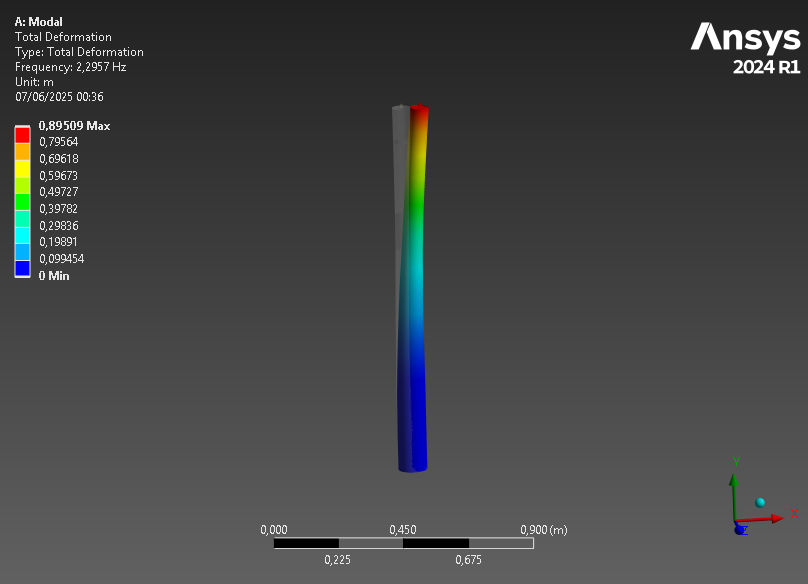

## Configuração com um modelo cheio com material ideal





```

        ***** MODAL MASSES, KINETIC ENERGIES, AND TRANSLATIONAL EFFECTIVE MASSES SUMMARY *****

                                                                         EFFECTIVE MASS
  MODE  FREQUENCY   MODAL MASS     KENE      |      X-DIR      RATIO%   Y-DIR      RATIO%   Z-DIR      RATIO%
     1   2.327       9.225       985.9       |    0.8590E-01    0.56  0.3161E-06    0.00   10.77       69.99
     2   2.337       9.219       994.2       |     10.76       69.89  0.6175E-06    0.00  0.8517E-01    0.55
     3   21.54       2.397      0.2195E+05   |    0.1392E-02    0.01  0.6805E-04    0.00   2.058       13.37
     4   21.66       2.384      0.2208E+05   |     2.055       13.35  0.1365E-04    0.00  0.1514E-02    0.01
     5   57.84       9.469      0.6254E+06   |    0.8678E-03    0.01   11.78       76.52  0.2189E-06    0.00
     6   62.35       2.256      0.1731E+06   |    0.5576E-01    0.36  0.8644E-03    0.01  0.7573        4.92
 --------------------------------------------------------------------------------------------------------------
   sum                                       |     12.96       84.18   11.78       76.52   13.68       88.85
 --------------------------------------------------------------------------------------------------------------


```



In [ ]:
erro_1 = abs((2.327-freqs_ideal.tempel)/freqs_ideal.tempel)*100

6.592453039011849

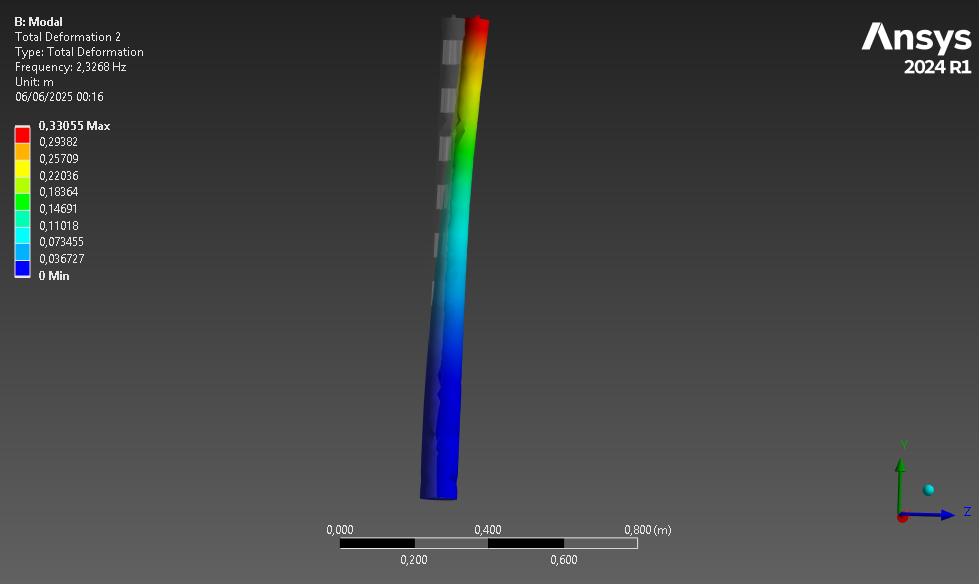

## ABS




```
# Isto está formatado como código



normalized modes.                                                       

        ***** MODAL MASSES, KINETIC ENERGIES, AND TRANSLATIONAL EFFECTIVE MASSES SUMMARY *****

                                                                         EFFECTIVE MASS
  MODE  FREQUENCY   MODAL MASS     KENE      |      X-DIR      RATIO%   Y-DIR      RATIO%   Z-DIR      RATIO%
     1   4.284       10.62       3847.       |    0.6670E-01    0.39  0.3057E-06    0.00   12.25       72.26
     2   4.303       10.61       3880.       |     12.23       72.17  0.6962E-06    0.00  0.6608E-01    0.39
     3   42.06       2.433      0.8493E+05   |    0.1327E-02    0.01  0.8775E-04    0.00   2.107       12.44
     4   42.29       2.419      0.8543E+05   |     2.105       12.42  0.1557E-04    0.00  0.1447E-02    0.01
     5   106.7       11.05      0.2482E+07   |    0.2486E-03    0.00   13.24       78.10  0.2660E-05    0.00
     6   122.0       2.287      0.6716E+06   |    0.5635E-01    0.33  0.3764E-03    0.00  0.7741        4.57
 --------------------------------------------------------------------------------------------------------------
   sum                                       |     14.46       85.33   13.24       78.10   15.20       89.67
 --------------------------------------------------------------------------------------------------------------

```

In [ ]:
erro_1 = abs((4.284-freqs_final.tempel)/freqs_final.tempel)*100

7.284900939137656

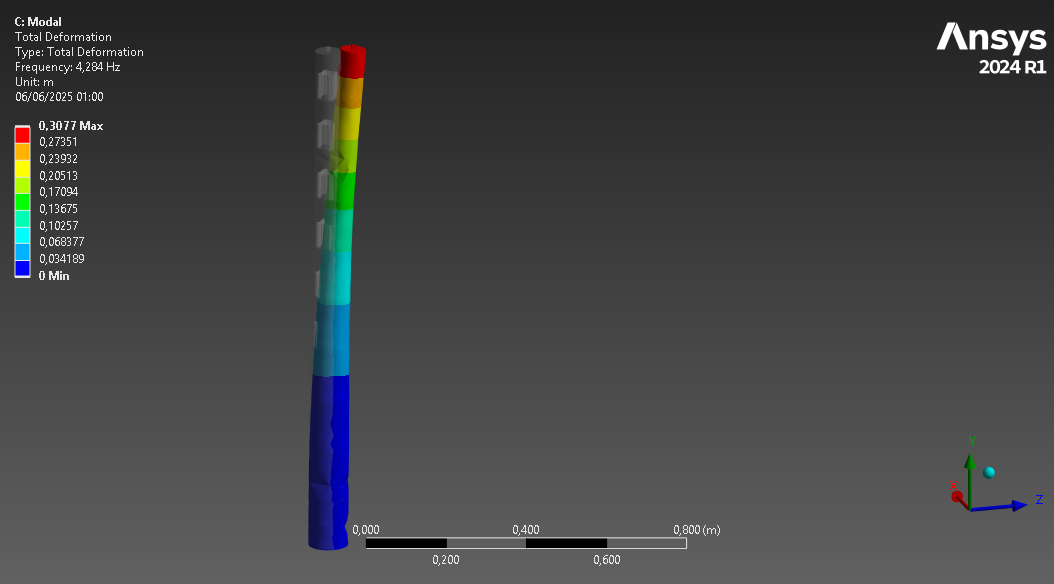

## ABS sem massa concentrada




```
# Isto está formatado como código



normalized modes.                                                       

        ***** MODAL MASSES, KINETIC ENERGIES, AND TRANSLATIONAL EFFECTIVE MASSES SUMMARY *****

                                                                         EFFECTIVE MASS
  MODE  FREQUENCY   MODAL MASS     KENE      |      X-DIR      RATIO%   Y-DIR      RATIO%   Z-DIR      RATIO%
     1   4.284       10.62       3847.       |    0.6670E-01    0.39  0.3057E-06    0.00   12.25       72.26
     2   4.303       10.61       3880.       |     12.23       72.17  0.6962E-06    0.00  0.6608E-01    0.39
     3   42.06       2.433      0.8493E+05   |    0.1327E-02    0.01  0.8775E-04    0.00   2.107       12.44
     4   42.29       2.419      0.8543E+05   |     2.105       12.42  0.1557E-04    0.00  0.1447E-02    0.01
     5   106.7       11.05      0.2482E+07   |    0.2486E-03    0.00   13.24       78.10  0.2660E-05    0.00
     6   122.0       2.287      0.6716E+06   |    0.5635E-01    0.33  0.3764E-03    0.00  0.7741        4.57
 --------------------------------------------------------------------------------------------------------------
   sum                                       |     14.46       85.33   13.24       78.10   15.20       89.67
 --------------------------------------------------------------------------------------------------------------

```

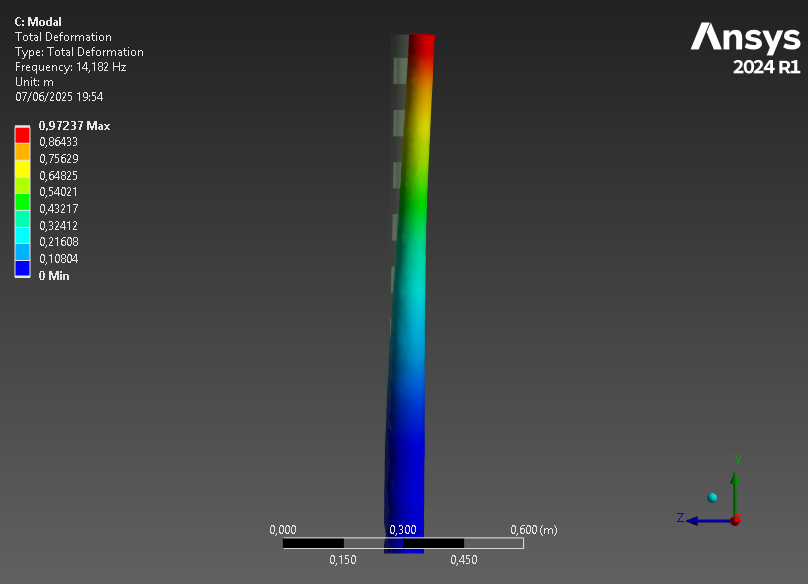

## Teste 1


### Bloco 1


```
    ***** MODAL MASSES, KINETIC ENERGIES, AND TRANSLATIONAL EFFECTIVE MASSES SUMMARY *****

                                                                         EFFECTIVE MASS
  MODE  FREQUENCY   MODAL MASS     KENE      |      X-DIR      RATIO%   Y-DIR      RATIO%   Z-DIR      RATIO%
     1   0.000      0.1369       0.000       |    0.6878E-01   17.69  0.5012E-02    1.29  0.5780E-01   14.87
     2   0.000      0.2320       0.000       |    0.1257       32.34  0.4461E-01   11.47  0.9861E-01   25.36
     3   0.000      0.1723       0.000       |    0.1045E-01    2.69  0.1469       37.78  0.1383       35.57
     4  0.3433E-03  0.1007      0.2341E-06   |    0.5198E-03    0.13  0.5450E-01   14.02  0.1003E-01    2.58
     5  0.5761E-03  0.1971      0.1291E-05   |    0.1188       30.56  0.1378       35.44  0.3484E-01    8.96
     6  0.9131E-03  0.1166      0.1920E-05   |    0.6450E-01   16.59  0.6139E-05    0.00  0.4919E-01   12.65
     7   3614.      0.9261E-01  0.2388E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
     8   3708.      0.1381      0.3748E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
     9   3709.      0.1380      0.3747E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
    10   5792.      0.1730      0.1146E+09   |     0.000        0.00   0.000        0.00   0.000        0.00
    11   6584.      0.8373E-01  0.7165E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
    12   6584.      0.8384E-01  0.7175E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
 --------------------------------------------------------------------------------------------------------------
   sum                                       |    0.3888      100.00  0.3888      100.00  0.3888      100.00
 --------------------------------------------------------------------------------------------------------------

```

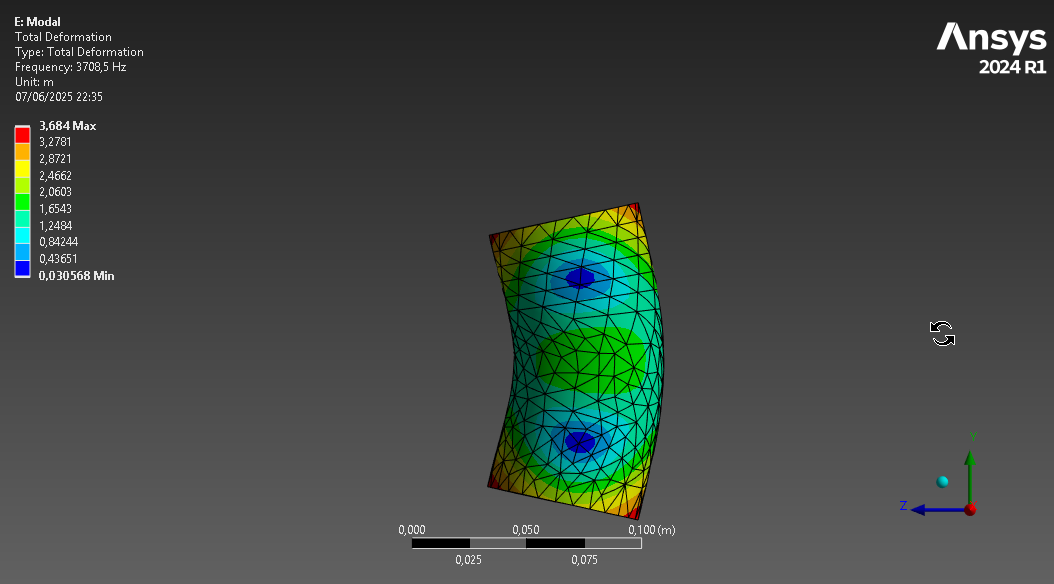

### Bloco 2

```
   ***** MODAL MASSES, KINETIC ENERGIES, AND TRANSLATIONAL EFFECTIVE MASSES SUMMARY *****

                                                                         EFFECTIVE MASS
  MODE  FREQUENCY   MODAL MASS     KENE      |      X-DIR      RATIO%   Y-DIR      RATIO%   Z-DIR      RATIO%
     1   0.000      0.1171       0.000       |    0.7944E-01   18.47  0.7867E-01   18.29  0.4947E-01   11.50
     2   0.000      0.1044       0.000       |    0.1213       28.21  0.3300E-01    7.67  0.2450E-01    5.70
     3   0.000      0.1833       0.000       |    0.8889E-01   20.67  0.3848E-01    8.95  0.1437       33.43
     4  0.2275E-03  0.2415      0.2468E-06   |    0.9247E-01   21.50  0.9812E-01   22.82  0.4568E-02    1.06
     5  0.3512E-03  0.9760E-01  0.2376E-06   |    0.4605E-01   10.71  0.1816E-01    4.22  0.2411E-03    0.06
     6  0.4714E-03  0.2309      0.1013E-05   |    0.1874E-02    0.44  0.1636       38.05  0.2075       48.26
     7   3061.      0.4495E-03  0.8315E+05   |     0.000        0.00   0.000        0.00   0.000        0.00
     8   3063.      0.5640E-03  0.1045E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
     9   3151.      0.3986E-03  0.7811E+05   |     0.000        0.00   0.000        0.00   0.000        0.00
    10   3160.      0.1178E-02  0.2322E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    11   3183.      0.4250E-03  0.8500E+05   |     0.000        0.00   0.000        0.00   0.000        0.00
    12   3214.      0.5901E-03  0.1203E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
 --------------------------------------------------------------------------------------------------------------
   sum                                       |    0.4301      100.00  0.4301      100.00  0.4301      100.00
 --------------------------------------------------------------------------------------------------------------
```

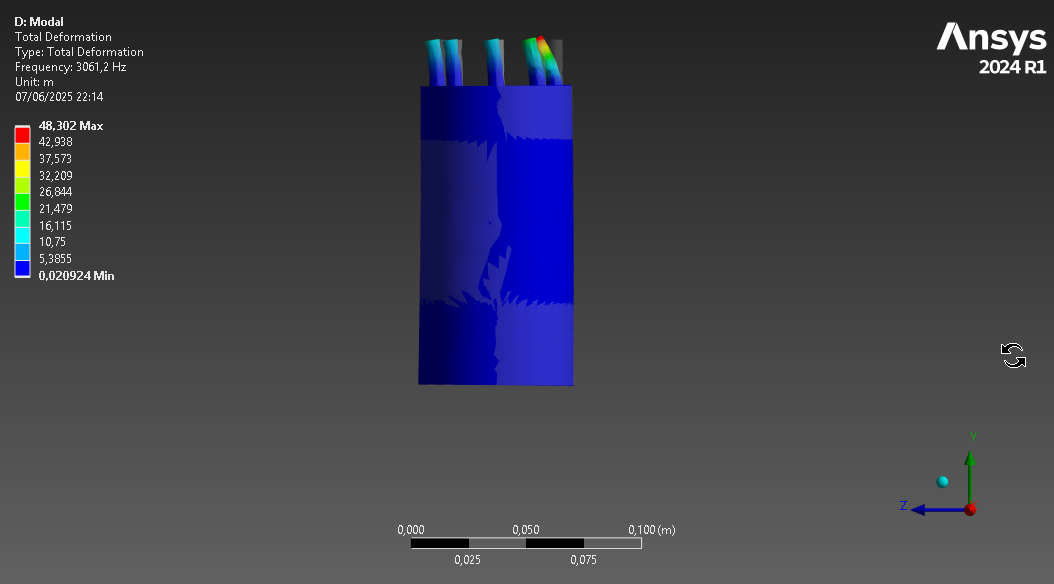

```
     ***** MODAL MASSES, KINETIC ENERGIES, AND TRANSLATIONAL EFFECTIVE MASSES SUMMARY *****

                                                                         EFFECTIVE MASS
  MODE  FREQUENCY   MODAL MASS     KENE      |      X-DIR      RATIO%   Y-DIR      RATIO%   Z-DIR      RATIO%
     1   0.000      0.1171       0.000       |    0.7944E-01   18.47  0.7867E-01   18.29  0.4947E-01   11.50
     2   0.000      0.1044       0.000       |    0.1213       28.21  0.3300E-01    7.67  0.2450E-01    5.70
     3   0.000      0.1833       0.000       |    0.8889E-01   20.67  0.3848E-01    8.95  0.1437       33.43
     4  0.2275E-03  0.2415      0.2468E-06   |    0.9247E-01   21.50  0.9812E-01   22.82  0.4568E-02    1.06
     5  0.3512E-03  0.9760E-01  0.2376E-06   |    0.4605E-01   10.71  0.1816E-01    4.22  0.2411E-03    0.06
     6  0.4714E-03  0.2309      0.1013E-05   |    0.1874E-02    0.44  0.1636       38.05  0.2075       48.26
     7   3061.      0.4495E-03  0.8315E+05   |     0.000        0.00   0.000        0.00   0.000        0.00
     8   3063.      0.5640E-03  0.1045E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
     9   3151.      0.3986E-03  0.7811E+05   |     0.000        0.00   0.000        0.00   0.000        0.00
    10   3160.      0.1178E-02  0.2322E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    11   3183.      0.4250E-03  0.8500E+05   |     0.000        0.00   0.000        0.00   0.000        0.00
    12   3214.      0.5901E-03  0.1203E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    13   3266.      0.3922E-03  0.8259E+05   |     0.000        0.00   0.000        0.00   0.000        0.00
    14   3272.      0.4650E-03  0.9826E+05   |     0.000        0.00   0.000        0.00   0.000        0.00
    15   3319.      0.6080E-03  0.1322E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    16   3332.      0.4449E-03  0.9748E+05   |     0.000        0.00   0.000        0.00   0.000        0.00
    17   3335.      0.2800E-03  0.6147E+05   |     0.000        0.00   0.000        0.00   0.000        0.00
    18   3346.      0.7712E-03  0.1704E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    19   3364.      0.8137E-03  0.1817E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    20   3368.      0.4053E-03  0.9076E+05   |     0.000        0.00   0.000        0.00   0.000        0.00
    21   3373.      0.4907E-03  0.1102E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    22   3380.      0.6839E-03  0.1542E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    23   3384.      0.3406E-03  0.7699E+05   |     0.000        0.00   0.000        0.00   0.000        0.00
    24   3404.      0.2186E-03  0.4999E+05   |     0.000        0.00   0.000        0.00   0.000        0.00
    25   3618.      0.2310E-02  0.5969E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    26   3755.      0.2163E-02  0.6020E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    27   3766.      0.1957E-02  0.5478E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    28   5443.      0.1520      0.8888E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
    29   6243.      0.5680E-01  0.4370E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
    30   6245.      0.5463E-01  0.4205E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
 --------------------------------------------------------------------------------------------------------------
   sum                                       |    0.4301      100.00  0.4301      100.00  0.4301      100.00
 --------------------------------------------------------------------------------------------------------------




```

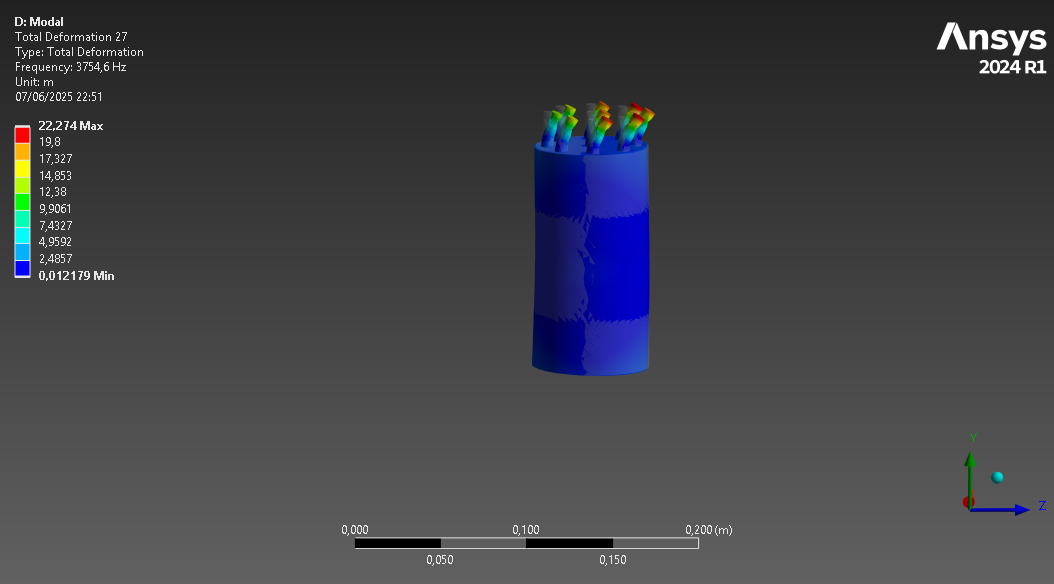

### Bloco 3


```
        ***** MODAL MASSES, KINETIC ENERGIES, AND TRANSLATIONAL EFFECTIVE MASSES SUMMARY *****

                                                                         EFFECTIVE MASS
  MODE  FREQUENCY   MODAL MASS     KENE      |      X-DIR      RATIO%   Y-DIR      RATIO%   Z-DIR      RATIO%
     1   0.000      0.1109       0.000       |    0.2932E-01    6.49  0.2213E-01    4.90  0.3729E-01    8.25
     2   0.000      0.1339       0.000       |    0.3040       67.30  0.7223E-03    0.16  0.5614E-01   12.43
     3  0.2038E-03  0.5798      0.4755E-06   |    0.2203E-01    4.88  0.2836       62.77  0.1408       31.16
     4  0.2801E-03  0.3106      0.4809E-06   |    0.9842E-02    2.18  0.1452       32.14  0.2172       48.08
     5  0.4632E-03  0.1322      0.5600E-06   |    0.3209E-01    7.10  0.5113E-04    0.01  0.6597E-06    0.00
     6  0.6052E-03  0.9219E-01  0.6666E-06   |    0.5447E-01   12.06  0.8994E-04    0.02  0.3241E-03    0.07
     7   3147.      0.2551E-02  0.4989E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
     8   3161.      0.3453E-02  0.6810E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
     9   3201.      0.2255E-02  0.4560E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    10   3339.      0.7570E-03  0.1666E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    11   3343.      0.3660E-03  0.8073E+05   |     0.000        0.00   0.000        0.00   0.000        0.00
    12   3354.      0.5253E-03  0.1167E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
 --------------------------------------------------------------------------------------------------------------
   sum                                       |    0.4518      100.00  0.4518      100.00  0.4518      100.00
 --------------------------------------------------------------------------------------------------------------
 ```

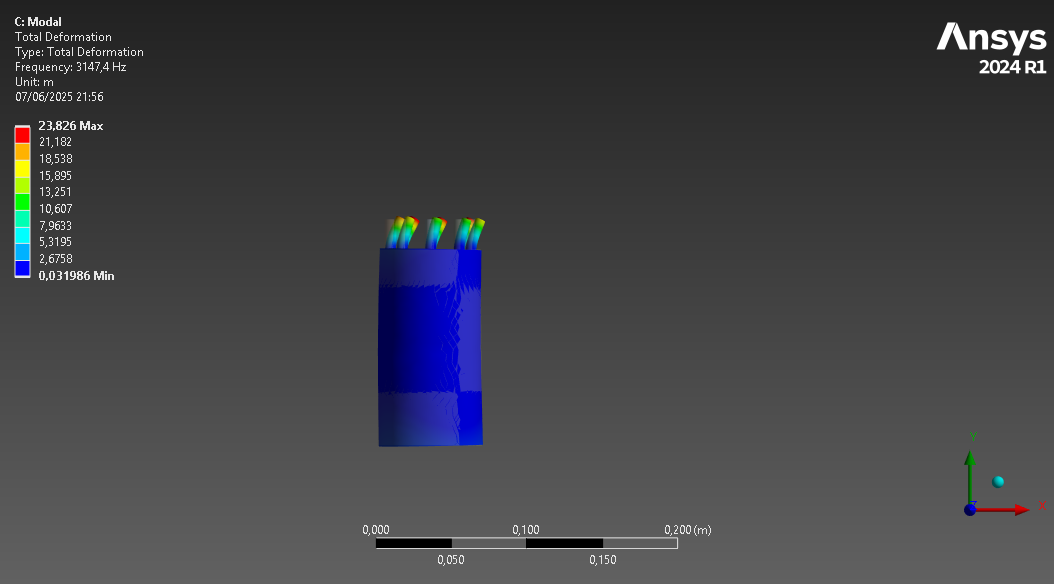

 ```
  ***** MODAL MASSES, KINETIC ENERGIES, AND TRANSLATIONAL EFFECTIVE MASSES SUMMARY *****

                                                                         EFFECTIVE MASS
  MODE  FREQUENCY   MODAL MASS     KENE      |      X-DIR      RATIO%   Y-DIR      RATIO%   Z-DIR      RATIO%
     1   0.000      0.1109       0.000       |    0.2932E-01    6.49  0.2213E-01    4.90  0.3729E-01    8.25
     2   0.000      0.1339       0.000       |    0.3040       67.30  0.7223E-03    0.16  0.5614E-01   12.43
     3  0.2038E-03  0.5798      0.4755E-06   |    0.2203E-01    4.88  0.2836       62.77  0.1408       31.16
     4  0.2801E-03  0.3106      0.4809E-06   |    0.9842E-02    2.18  0.1452       32.14  0.2172       48.08
     5  0.4632E-03  0.1322      0.5600E-06   |    0.3209E-01    7.10  0.5113E-04    0.01  0.6597E-06    0.00
     6  0.6052E-03  0.9219E-01  0.6666E-06   |    0.5447E-01   12.06  0.8994E-04    0.02  0.3241E-03    0.07
     7   3147.      0.2551E-02  0.4989E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
     8   3161.      0.3453E-02  0.6810E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
     9   3201.      0.2255E-02  0.4560E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    10   3339.      0.7570E-03  0.1666E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    11   3343.      0.3660E-03  0.8073E+05   |     0.000        0.00   0.000        0.00   0.000        0.00
    12   3354.      0.5253E-03  0.1167E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    13   3363.      0.4770E-03  0.1065E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    14   3374.      0.7303E-03  0.1641E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    15   3387.      0.6907E-03  0.1564E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    16   3397.      0.5023E-03  0.1144E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    17   3414.      0.7973E-03  0.1834E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    18   3418.      0.5463E-03  0.1260E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    19   3420.      0.4849E-03  0.1120E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    20   3431.      0.5965E-03  0.1386E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    21   3434.      0.4477E-03  0.1042E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    22   3438.      0.4463E-03  0.1041E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    23   3454.      0.1921E-03  0.4523E+05   |     0.000        0.00   0.000        0.00   0.000        0.00
    24   3495.      0.1868E-03  0.4504E+05   |     0.000        0.00   0.000        0.00   0.000        0.00
    25   3660.      0.1972E-02  0.5214E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    26   3818.      0.3053E-02  0.8784E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    27   3832.      0.2558E-02  0.7415E+06   |     0.000        0.00   0.000        0.00   0.000        0.00
    28   5440.      0.1650      0.9639E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
    29   6228.      0.6088E-01  0.4662E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
    30   6229.      0.6072E-01  0.4650E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
 --------------------------------------------------------------------------------------------------------------
   sum                                       |    0.4518      100.00  0.4518      100.00  0.4518      100.00
```

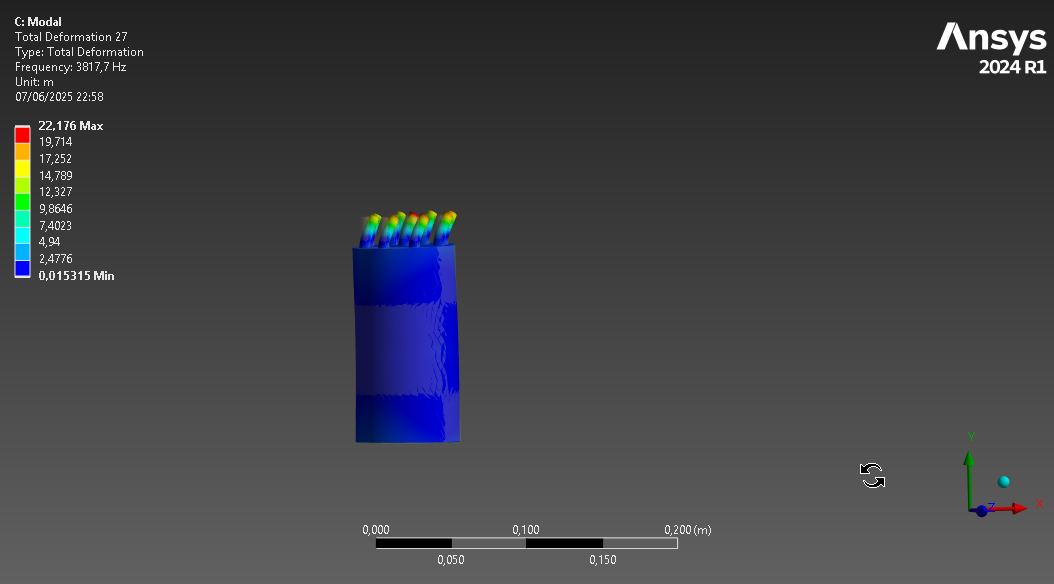

### 2 blocos



```

        ***** MODAL MASSES, KINETIC ENERGIES, AND TRANSLATIONAL EFFECTIVE MASSES SUMMARY *****

                                                                         EFFECTIVE MASS
  MODE  FREQUENCY   MODAL MASS     KENE      |      X-DIR      RATIO%   Y-DIR      RATIO%   Z-DIR      RATIO%
     1   0.000      0.1940       0.000       |    0.2149E-01    2.60  0.4693E-01    5.69  0.4332       52.51
     2   0.000      0.2022       0.000       |    0.5657E-01    6.86  0.5760E-03    0.07  0.5566E-01    6.75
     3  0.3564E-04  0.2055      0.5151E-08   |    0.8037E-01    9.74  0.1359       16.48  0.5198E-01    6.30
     4  0.1251E-03  0.1843      0.5692E-07   |    0.1622E-01    1.97  0.7904E-02    0.96  0.2803       33.97
     5  0.1907E-03  0.3637      0.2609E-06   |    0.6025       73.03  0.1257       15.24  0.1833E-02    0.22
     6  0.2289E-03  0.5670      0.5864E-06   |    0.4787E-01    5.80  0.5080       61.57  0.2054E-02    0.25
     7   1139.      0.3998      0.1025E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
     8   1139.      0.3996      0.1024E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
     9   1730.      0.1988      0.1174E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
    10   2618.      0.3158      0.4271E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
    11   2618.      0.3152      0.4264E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
    12   2835.      0.3918      0.6217E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
 --------------------------------------------------------------------------------------------------------------
   sum                                       |    0.8250      100.00  0.8250      100.00  0.8250      100.00
 --------------------------------------------------------------------------------------------------------------



```

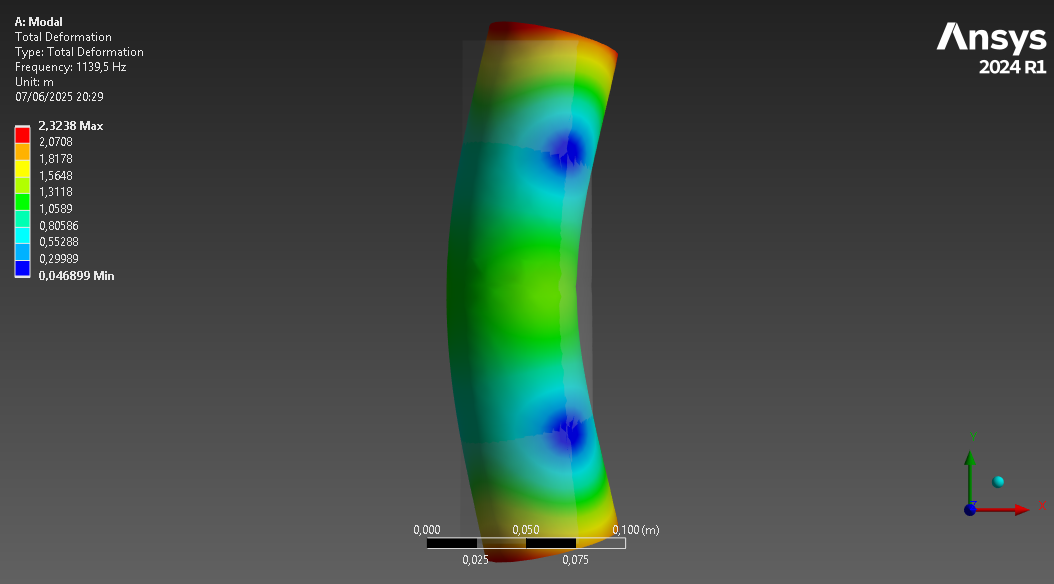

### 3 blocos acoplados


```


        ***** MODAL MASSES, KINETIC ENERGIES, AND TRANSLATIONAL EFFECTIVE MASSES SUMMARY *****

                                                                         EFFECTIVE MASS
  MODE  FREQUENCY   MODAL MASS     KENE      |      X-DIR      RATIO%   Y-DIR      RATIO%   Z-DIR      RATIO%
     1   0.000      0.2550       0.000       |    0.3002E-01    2.35  0.1192E-01    0.93  0.2981       23.34
     2   0.000      0.4853       0.000       |    0.1007        7.88  0.5057       39.59  0.3195E-02    0.25
     3   0.000      0.6598       0.000       |    0.2905E-01    2.27  0.6376       49.92  0.3427E-02    0.27
     4  0.7989E-04  0.8751      0.1102E-06   |    0.8573       67.12  0.1151        9.01  0.2547       19.94
     5  0.1267E-03  0.3432      0.1087E-06   |    0.1654       12.95  0.6280E-04    0.00  0.6693       52.40
     6  0.2218E-03  0.2695      0.2617E-06   |    0.9491E-01    7.43  0.6814E-02    0.53  0.4858E-01    3.80
     7   542.3      0.3338      0.1938E+07   |     0.000        0.00   0.000        0.00   0.000        0.00
     8   542.3      0.3338      0.1938E+07   |     0.000        0.00   0.000        0.00   0.000        0.00
     9   1146.      0.2956      0.7658E+07   |     0.000        0.00   0.000        0.00   0.000        0.00
    10   1346.      0.3798      0.1358E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
    11   1346.      0.3799      0.1359E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
    12   1881.      0.5941      0.4151E+08   |     0.000        0.00   0.000        0.00   0.000        0.00
 --------------------------------------------------------------------------------------------------------------
   sum                                       |     1.277      100.00   1.277      100.00   1.277      100.00
 --------------------------------------------------------------------------------------------------------------

```

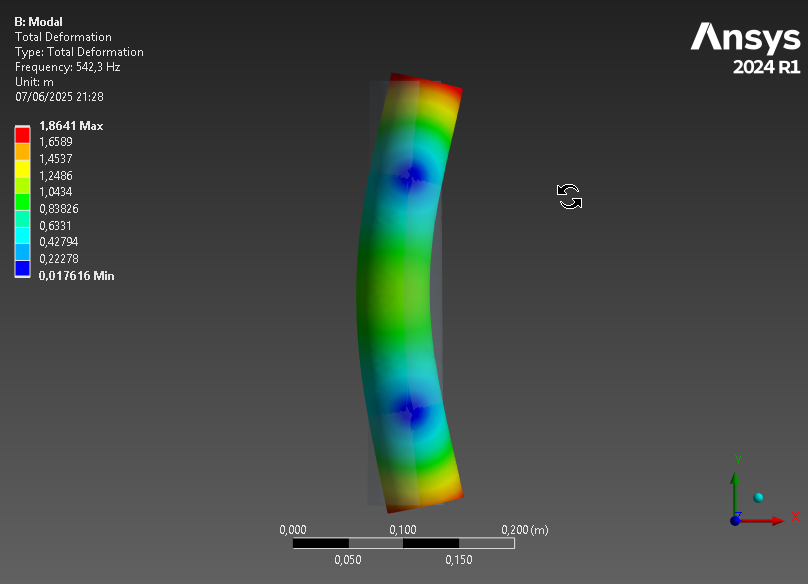